# GAN para generar imágenes de prendas y accesorios

Nombre : Alejandro Fernánde Barrionuevo

## Importación de librerías

In [64]:
# Importa las librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

## Carga de datos

Trabajaremos con un conjunto de imágenes de ropa y calzado: vestidos, camisetas, zapatos abiertos, zapatillas, etc.

<img src="https://drive.google.com/uc?id=1b95TdzfDYMG7gL6D-JTkO0RNvHKsRhWD">

In [65]:
fashion_mnist = keras.datasets.fashion_mnist

In [66]:
(X_train_full, y_train_full), (X_test, y_test)= fashion_mnist.load_data()

## Exploración de datos

In [67]:
print(f"Tamaño del conjunto de entrenamiento: {X_train_full.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (60000, 28, 28)
Tamaño del conjunto de prueba: (10000, 28, 28)


In [68]:
print(f"Etiquetas disponibles: {set(y_train_full)}")

Etiquetas disponibles: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


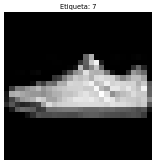

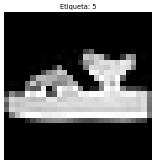

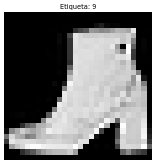

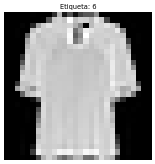

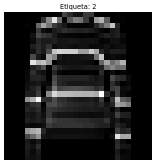

In [69]:
# Seleccionar 5 imágenes aleatorias
sample_indices = random.sample(range(X_train_full.shape[0]), 5)

for idx in sample_indices:
    img = X_train_full[idx]
    plt.figure(dpi=40)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Etiqueta: {y_train_full[idx]}")
    plt.show()

## Preparación de los datos

### Normalizar las imágenes

In [70]:
X_train_full = (X_train_full.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

* Convierte los valores de píxeles de 0 a 255 a un rango entre -1 y 1.
* Ayuda a que el entrenamiento de la GAN sea más estable y rápido, ya que las redes neuronales funcionan mejor con valores pequeños y centrados en 0.

### Expandir Dimensiones para Red Convencionales

In [71]:
X_train_full = np.expand_dims(X_train_full, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

* Las imágenes en Fashion MNIST tienen dimensiones (28, 28), pero las redes convolucionales esperan un formato de imagen con canales: (28, 28, 1).
* `axis=-1` agrega la dimensión del canal de color (aunque las imágenes son en escala de grises, es obligatorio para TensorFlow).

### Crear Batches para el Entrenamiento

In [72]:
IMG_SIZE = (28, 28)
BATCH_SIZE = 256  # Se puede probar con 64, 128 o más
NUMBER_OF_IMAGES = 60000  # Se puede reducir según recursos disponibles

* Divide los datos en batches (lotes de imágenes) para entrenar la GAN de manera más eficiente.
* `BATCH_SIZE = 256` significa que el modelo procesará 256 imágenes por iteración en la red neuronal.

## Procesamiento

In [73]:
# Crear dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices(X_train_full[:NUMBER_OF_IMAGES])
dataset = dataset.shuffle(NUMBER_OF_IMAGES).batch(BATCH_SIZE)

* Normaliza las imágenes a un rango de [-1, 1] para que la GAN converja mejor.
* Expande dimensiones a (28,28,1) para usarlo en redes convolucionales.
* Crea el dataset de TensorFlow y lo organiza en batches de 256 imágenes.
* Imprime el número total de imágenes procesadas.

### Verificar estructura del dataset

In [74]:
for batch in dataset.take(1):  # Tomar un solo lote
    print("Dimensiones del lote:", batch.shape)
    print("Rango de valores: de", batch.numpy().min(), "a", batch.numpy().max())

Dimensiones del lote: (256, 28, 28, 1)
Rango de valores: de -1.0 a 1.0


* Muestra el tamaño de un batch (debería ser (256, 28, 28, 1)).
* Confirma que los valores están normalizados entre -1 y 1.

## Definición de **Generador**

In [75]:
LATENT_DIM = 150

generator = keras.Sequential([
    # Capa densa inicial
    layers.Dense(7 * 7 * 256, input_shape=(LATENT_DIM,)),  # Más filtros para más capacidad de aprendizaje
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Redimensión a las dimensiones iniciales
    layers.Reshape((7, 7, 256)),  # Se convierte en un "mapa de características"

    # Primera capa de convolución transpuesta
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Segunda capa de convolución transpuesta
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Tercera capa: Mejora los detalles
    layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Cuarta capa: Refina texturas
    layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Capa final para generar la imagen de 28x28x1
    layers.Conv2D(1, (5, 5), activation="tanh", padding="same")  # Imagen en escala de grises
])

generator.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 12544)               │       1,894,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 14, 14, 128)         │         819,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 28, 28, 64)          │         204,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_21 (LeakyReLU)           │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 28, 28, 32)          │          51,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 28, 28, 16)          │          12,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 1)           │             4

 Total params: 3,033,681 (11.57 MB)

 Trainable params: 3,008,113 (11.48 MB)

 Non-trainable params: 25,568 (99.88 KB)

In [76]:
# Dimensiones de cada capa
noise = tf.random.normal([1, LATENT_DIM])
x = noise
for layer in generator.layers:
  x = layer(x)
  print(f"{layer.name}: {x.shape}")

dense_6: (1, 12544)
batch_normalization_13: (1, 12544)
leaky_re_lu_19: (1, 12544)
reshape_3: (1, 7, 7, 256)
conv2d_transpose_10: (1, 14, 14, 128)
batch_normalization_14: (1, 14, 14, 128)
leaky_re_lu_20: (1, 14, 14, 128)
conv2d_transpose_11: (1, 28, 28, 64)
batch_normalization_15: (1, 28, 28, 64)
leaky_re_lu_21: (1, 28, 28, 64)
conv2d_transpose_12: (1, 28, 28, 32)
batch_normalization_16: (1, 28, 28, 32)
leaky_re_lu_22: (1, 28, 28, 32)
conv2d_transpose_13: (1, 28, 28, 16)
batch_normalization_17: (1, 28, 28, 16)
leaky_re_lu_23: (1, 28, 28, 16)
conv2d_9: (1, 28, 28, 1)


In [77]:
generated_image = generator(noise , training=False) # Le indicamos que no estamos en un entrenamiento
print("Dimensiones de la imagen generada: ", generated_image.shape)

Dimensiones de la imagen generada:  (1, 28, 28, 1)


### Comprobación del Generador

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


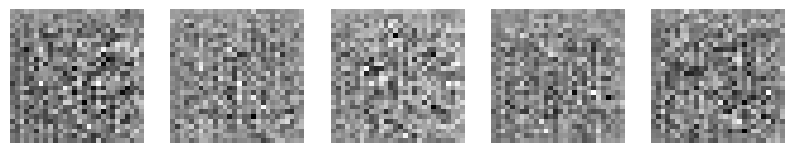

In [78]:
# Generar imágenes aleatorias a partir de ruido
num_images = 5  # Cantidad de imágenes a generar
random_latent_vectors = np.random.normal(0, 1, (num_images, LATENT_DIM))  # Generar ruido aleatorio

# Crear imágenes con el generador
generated_images = generator.predict(random_latent_vectors)

# Desnormalizar imágenes (pasar de [-1,1] a [0,1] para visualización)
generated_images = (generated_images + 1) / 2.0

# Mostrar imágenes generadas
plt.figure(figsize=(10, 2))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap="gray")
    plt.axis("off")
plt.show()

## Definición de **Discriminador**

In [79]:
# Define el discriminador
discriminator = keras.Sequential([
    # Primera capa de convolución
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),

    # Segunda capa de convolución
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),

    # Aplanar y capa densa de salida
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")  # Salida entre 0 (falso) y 1 (real)
])

discriminator.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

### Comprobación del Discriminador

In [80]:
# Prueba el discriminador con una imagen creada por el generador
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Pasa la imagen por el discriminador
decision = discriminator(generated_image)
print("Decisión del discriminador (valor cercano a 0 = falsa, 1 = real): ", decision.numpy())

Decisión del discriminador (valor cercano a 0 = falsa, 1 = real):  [[0.49991164]]


Es normal que el discriminador indique incertidumbre porque todavía no hemos entrenado la GAN.

## Entrenamiento de la GAN

### Parámetros del entrenamiento

In [81]:
EPOCHS = 100
LATENT_DIM = 150
BATCH_SIZE = 50

* `EPOCHS`: Número de veces que el modelo verá todo el dataset.
* `LATENT_DIM`: Dimensión del vector de entrada para el generador.
* `BATCH_SIZE`: Número de imágenes procesadas en cada iteración.

### Inicializar Optimizadores y Función de Pérdida

In [82]:
# Inicializa los optimizadores y la función de pérdida
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False) # No usamos logits porque la última capa era sigmoide
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

* `cross_entropy` mide la diferencia entre las predicciones y las etiquetas reales.
* **Adam (1e-4)** es un optimizador eficiente para redes neuronales profundas.

In [83]:
for epoch in range(EPOCHS):
    print(f"Época {epoch + 1}/{EPOCHS}")

    i = 0  # Inicializamos el contador

    for real_image in dataset:  # Recorremos el dataset
        current_batch_size = real_image.shape[0]  # Tamaño real del batch

        # Generamos ruido para crear imágenes falsas
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Creamos imágenes falsas con el generador
        generated_image = generator(noise, training=True) # Modo entrenamiento

        # Etiquetas reales y falsas
        real_labels = tf.ones((current_batch_size, 1)) # 1 = imagen real
        fake_labels = tf.zeros((current_batch_size, 1)) # 0 = imagen falsa

        # Entrenamiento del Discriminador
        with tf.GradientTape() as disc_tape:
            real_output = discriminator(real_image, training=True)
            fake_output = discriminator(generated_image, training=True)

            disc_loss_real = cross_entropy(real_labels, real_output)
            disc_loss_fake = cross_entropy(fake_labels, fake_output)

            disc_loss = disc_loss_real + disc_loss_fake

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Generamos ruido nuevamente para entrenar el Generador
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Entrenamiento del Generador
        with tf.GradientTape() as gen_tape:
            generated_image = generator(noise, training=True)
            fake_output = discriminator(generated_image, training=False) # No actualizamos el discriminador
            gen_loss = cross_entropy(real_labels, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        print(f"Batch {i + 1}: Pérdida Discriminador: {disc_loss.numpy()}, Pérdida Generador: {gen_loss.numpy()}")

        i += 1  # Incrementamos el contador

        # Prueba con esto para ver si el bucle avanza de época
        if i == BATCH_SIZE:  # Procesar hasta el máximo de batches indicado
            break

Se han truncado las últimas 5000 líneas del flujo de salida.
Batch 49: Pérdida Discriminador: 1.455535888671875, Pérdida Generador: 0.5877779126167297
Batch 50: Pérdida Discriminador: 1.4377498626708984, Pérdida Generador: 0.6092139482498169
Época 3/100
Batch 1: Pérdida Discriminador: 1.4214446544647217, Pérdida Generador: 0.6291257739067078
Batch 2: Pérdida Discriminador: 1.4039006233215332, Pérdida Generador: 0.6485532522201538
Batch 3: Pérdida Discriminador: 1.3606011867523193, Pérdida Generador: 0.6667086482048035
Batch 4: Pérdida Discriminador: 1.3635990619659424, Pérdida Generador: 0.6888927817344666
Batch 5: Pérdida Discriminador: 1.3090131282806396, Pérdida Generador: 0.7025132179260254
Batch 6: Pérdida Discriminador: 1.2807796001434326, Pérdida Generador: 0.7179531455039978
Batch 7: Pérdida Discriminador: 1.2812483310699463, Pérdida Generador: 0.7355492115020752
Batch 8: Pérdida Discriminador: 1.2654107809066772, Pérdida Generador: 0.7466065287590027
Batch 9: Pérdida Discrimin

* Entrenamos el Discriminador con imágenes reales y falsas.
* Entrenamos el Generador para engañar al Discriminador.
* Las pérdidas (`disc_loss`, `gen_loss`) se imprimen para monitorear el aprendizaje.

## Guardado de modelos de la GAN

In [84]:
generator.save(f"generador_fashion_{EPOCHS+1}ep.keras")
discriminator.save(f"discriminador_fashion_{EPOCHS+1}ep.keras")

* Permite reutilizar los modelos sin necesidad de volver a entrenarlos.

## Cargado del generador y generación de imágenes nuevas

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


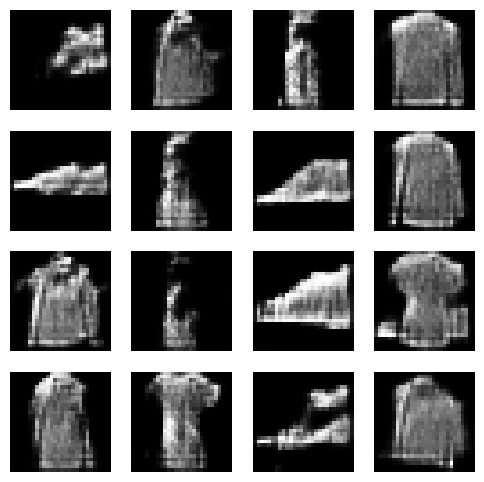

In [86]:
# Cargar el modelo entrenado
generator = load_model("/content/generador_fashion_101ep.keras")

# Generar imágenes nuevas
LATENT_DIM = 150  # Debe coincidir con el usado en el entrenamiento
num_images = 16  # Cantidad de imágenes a generar
noise = np.random.normal(0, 1, (num_images, LATENT_DIM))  # Ruido aleatorio

generated_images = generator.predict(noise)  # Generar imágenes
generated_images = (generated_images + 1) / 2  # Reescalar de [-1,1] a [0,1]

# Mostrar las imágenes generadas
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for img, ax in zip(generated_images, axes.flatten()):
    ax.imshow(img, cmap="gray")  # Cambia cmap si es a color
    ax.axis("off")
plt.show()